<h1>Aplication of stepwise linear regression for predicting values of SPI from values of MEI index</h1>
<p>In this project the metodology implemented in Wikarmpapraharn and Kositsakulchai (2010) paper called <a href='https://li01.tci-thaijo.org/index.php/anres/article/view/244982'><em>Relationship between ENSO and rainfall in the central plain of thailand</em></a> is applied to get a linear model that predicts the values of the <a href='https://sissa.crc-sas.org/monitoreo/indices-de-sequia/'>Standarize Precipitation Index</a> (SPI) from the values of the <a href='https://psl.noaa.gov/enso/mei/'>Multivariate ENSO Index Version 2</a> (MEI). The goal is to obtain an optimal model taking only the regressors which are statistically significant applying stepwise linear regression.</p>

In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from src.extract_and_load import extract_and_load
from src.plots import mei_vs_spi
from src.data_utils import to_time_series
import os
from src.linear_regression import LinearRegression
from src.stepwise_regression import StepwiseRegression

<h2>01 - Extraction and load of data</h2>
    <p>The data is extracted from csv files located in the input directory. The data related to the MEI where obtained from the <a href='https://psl.noaa.gov/enso/mei/#data'>
Physical Sciences Laboratory</a> of the National Oceanic Atmospheric Administration (EE.UU.), and the data of the SPI where provided by Direction of Meteodology and Hidrology (DMH), Paraguay.</p>

In [2]:
database = extract_and_load()

<p>The database consists of a dictionary where each key refers either to a meteorological station in Paraguay, and its value is a daframe with the different SPI values for each month in the period 1981-2010, or to a dataframe with the MEI values from the same period.</p>

In [3]:
database['asu'].head()

Año  Mes     SPI_1     SPI_2     SPI_3     SPI_4     SPI_5     SPI_6  \
0  1981    1  0.273339 -0.172314  0.273339 -0.104202 -0.104202  0.345271   
1  1981    2  1.450266  1.268487  0.692564  0.785365  0.564000  0.483623   
2  1981    3 -0.557307  0.738130  0.692564  0.406478  0.483623  0.188237   
3  1981    4  0.118296 -0.157314  0.692564  0.523359  0.295374  0.406478   
4  1981    5 -0.637684 -0.480162 -0.811814  0.295374  0.295374  0.118296   

      SPI_7     SPI_8     SPI_9    SPI_10    SPI_11    SPI_12  
0 -0.138199 -0.172314  0.381968  0.309081  0.309081  0.381968  
1  0.648464  0.605659  0.564000  0.834510  0.834510  0.605659  
2  0.118296  0.523359  0.368901  0.331888  0.523359  0.444692  
3  0.153150  0.188237  0.444692  0.188237  0.188237  0.564000  
4  0.295374  0.083629  0.083629  0.368901  0.259298  0.153150

In [4]:
database['mei'].head()

1     2     3     4     5     6     7     8     9    10    11    12
0 -0.28 -0.19  0.16  0.15 -0.38 -0.63 -0.51 -0.25  0.03 -0.05 -0.16 -0.18
1 -0.44 -0.61 -0.31  0.13  0.66  1.42  1.87  1.93  1.74  1.87  2.25  2.45
2  2.59  2.73  2.71  2.74  2.60  1.58  0.88  0.03 -0.41 -0.44 -0.42 -0.44
3 -0.38 -0.36 -0.06 -0.06 -0.78 -0.75 -0.23 -0.02 -0.06 -0.01 -0.59 -0.32
4 -0.31 -0.57 -0.51 -0.68 -1.04 -0.24 -0.02 -0.36 -0.35  0.05  0.11 -0.36

<h2>02 - Transform</h2>
<p>Here the MEI values will be stardarized</p>

In [5]:
scaler = StandardScaler()

In [6]:
bimonthly = ['JAN/FEB','FEB/MAR','MAR/APR','APR/MAY','MAY/JUN','JUN/JUL','JUL/AUG','AUG/SEP','SEP/OCT','OCT/NOV','NOV/DEC','DEC/JAN']

In [8]:
A = pd.DataFrame(scaler.fit_transform(database['mei']),columns=bimonthly)

In [9]:
A.head()

JAN/FEB   FEB/MAR   MAR/APR   APR/MAY   MAY/JUN   JUN/JUL   JUL/AUG  \
0 -0.354482 -0.247800  0.083428  0.079722 -0.400166 -0.653501 -0.505692   
1 -0.518720 -0.662445 -0.377880  0.059539  0.622371  1.353004  1.791154   
2  2.591547  2.634971  2.586270  2.693393  2.529796  1.509609  0.835743   
3 -0.457131 -0.415632 -0.132503 -0.132197 -0.793449 -0.770954 -0.235475   
4 -0.385276 -0.622955 -0.574181 -0.757864 -1.049084 -0.271775 -0.032812   

    AUG/SEP   SEP/OCT   OCT/NOV   NOV/DEC   DEC/JAN  
0 -0.243221  0.021735 -0.062687 -0.161906 -0.175950  
1  1.847006  1.711129  1.837717  2.165287  2.371292  
2  0.025249 -0.412963 -0.448707 -0.412972 -0.427769  
3 -0.022692 -0.067181 -0.023095 -0.577131 -0.311545  
4 -0.348691 -0.353686  0.036292  0.098817 -0.350286

<h2>03 - Applying the technique</h2>
<p>The strategy is the following: the $SPI_i$ value of a given month, where $i$ is an integer from 1 to 6, has to be predicted with a linear model described as the formal sum of the $\tilde{MEI}$, the standarized values of the $MEI$ </p>
$$SPI_i=\sum_{j=1}^{12}\alpha_j\tilde{MEI}_j$$
<p>being $\alpha_i$ real numbers. This coefficients will be zero if the regressor is not statistically significant, meaning that the p-value realted to a $\tilde{MEI}_j$ has to be greater than 0.05.</p>

In [10]:
stpwr = StepwiseRegression()

<p>The the data of each station is reshape in order to obtain a dataframe for each SPI type. The linear models generated are asked to reach a $R^2$ 0.8 in order to be considered.</p>

In [22]:
# Initializing a dictionary that will contain the regression results.
regressions = {}
# Months array for the dataframes columns.
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
# Going through each station dataframe; when the MEI dataframe is encountered, it is omitted.
for key in database:
    if key=='mei':
        continue
    # Initializing an auxiliary dictionary.
    aux_dict = {}
    # Taking the SPI values from 1 to 6 months.
    for spi in database[key].iloc[:,2:8]:
    # Transforming a SPI column into a dataframe.
        Y = pd.DataFrame(database[key].iloc[:,2:][spi].values.reshape(30,12),columns=months)
    # Applying the stepwise linear regression to each month.    
        for y in Y:
            stpwr.fit(A,Y[y])
    # Discarting from the list those stations that doesn't get a linear model.
            if stpwr.anova_report.shape!=(0,0):
    # The R^2 value of the model must be equal or greater than 0.8 to be considered.
                for r2 in stpwr.anova_report['R^2']: 
                    if r2 >= 0.8:
                        aux_dict[spi+'_'+y]=stpwr.anova_report
    regressions[key] = aux_dict

<p>The following datframe contains the $SPI_6$ values of the Concepción station.</p>

In [16]:
Y.head()

JAN       FEB       MAR       APR       MAY       JUN       JUL  \
0 -0.241064 -0.054012 -0.518376 -1.523950 -1.636885 -0.859050 -0.637684   
1 -0.070284  0.223603  1.268487  0.153150 -2.242653 -1.013442 -0.157314   
2  1.708044  0.444692  0.444692  2.652636  2.652636  2.652636  0.605659   
3 -1.022014 -1.342171  0.118296  1.057118 -0.480162 -1.523950 -0.722148   
4  0.495786 -1.427321  1.057118  1.191874  0.605659  0.083629  0.885856   

        AUG       SEP       OCT       NOV       DEC  
0 -0.261921 -0.442585 -1.957344 -0.908195  0.523359  
1 -0.557307  0.483623  1.121866  0.996658  1.450266  
2  0.014687 -0.480162 -0.557307 -1.070342 -1.195550  
3  0.295374 -0.332982 -0.859050  1.121866  1.883660  
4  0.785365 -1.013442 -1.523950 -1.636885 -1.070342

In [21]:
# Going through every model. 
for key in regressions:
    if regressions[key] != {}:
# If there is a model for a particual station, print its report.
        print(key,regressions[key])

<p>None of the models under this methodology meet the requirements. Further analysis will be conducted to search for a model that can predict the SPI_2 values with an $R^2$ value of 0.5 or greater.</p>

In [13]:
regressions_spi2 = {}
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
for key in database:
    if key=='mei':
        continue
    aux_dict = {}
    Y = pd.DataFrame(database[key].iloc[:,2:]['SPI_2'].values.reshape(30,12),columns=months)
    for y in Y:
        stpwr.fit(A,Y[y])
        if stpwr.anova_report.shape!=(0,0):
            for r2 in stpwr.anova_report['R^2']: 
                if r2 > 0.5:
                    aux_dict['SPI_2']=stpwr.anova_report
    regressions_spi2[key] = aux_dict

In [14]:
for key in regressions_spi2:
    if regressions_spi2[key] != {}:
        print(key,regressions_spi2[key]['SPI_2'])

gua   Regressor   Coeff  Standard Error  t-statistic  p-value     R^2  \
0   APR/MAY  0.4170          0.1275       3.2699   0.0029  0.2763   
1   FEB/MAR -0.6701          0.2683       2.4981   0.0189  0.4122   
2   JUL/AUG -0.5002          0.1449       3.4520   0.0019  0.5969   

   R_2 adjusted  
0        0.2505  
1        0.3687  
2        0.5504  
cov   Regressor   Coeff  Standard Error  t-statistic  p-value     R^2  \
0   APR/MAY  0.2876          0.1272       2.2607   0.0317  0.1544   
1   JAN/FEB -0.6027          0.2616       2.3043   0.0291  0.2933   
2   JUL/AUG -0.3044          0.1478       2.0593   0.0496  0.3924   
3   DEC/JAN  0.6590          0.2492       2.6438   0.0140  0.5252   

   R_2 adjusted  
0        0.1242  
1        0.2410  
2        0.3223  
3        0.4492  


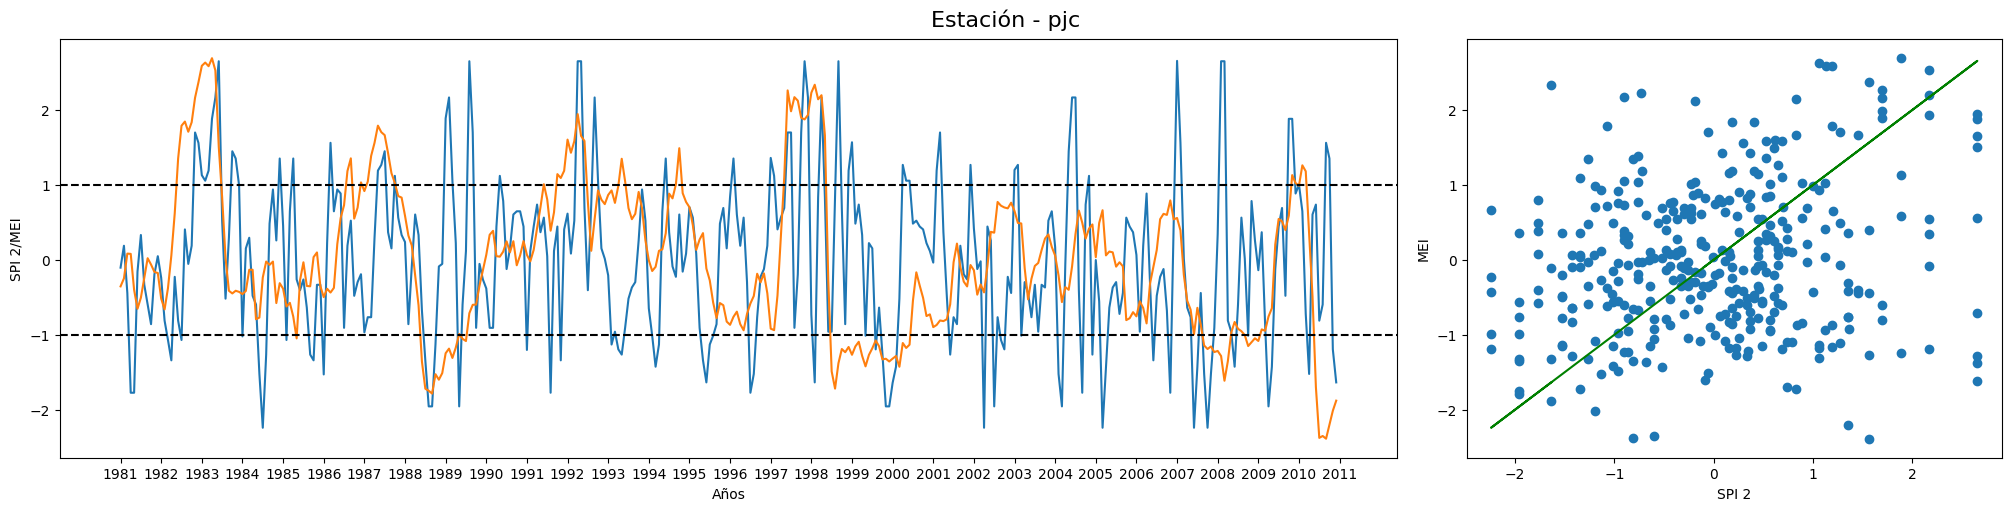

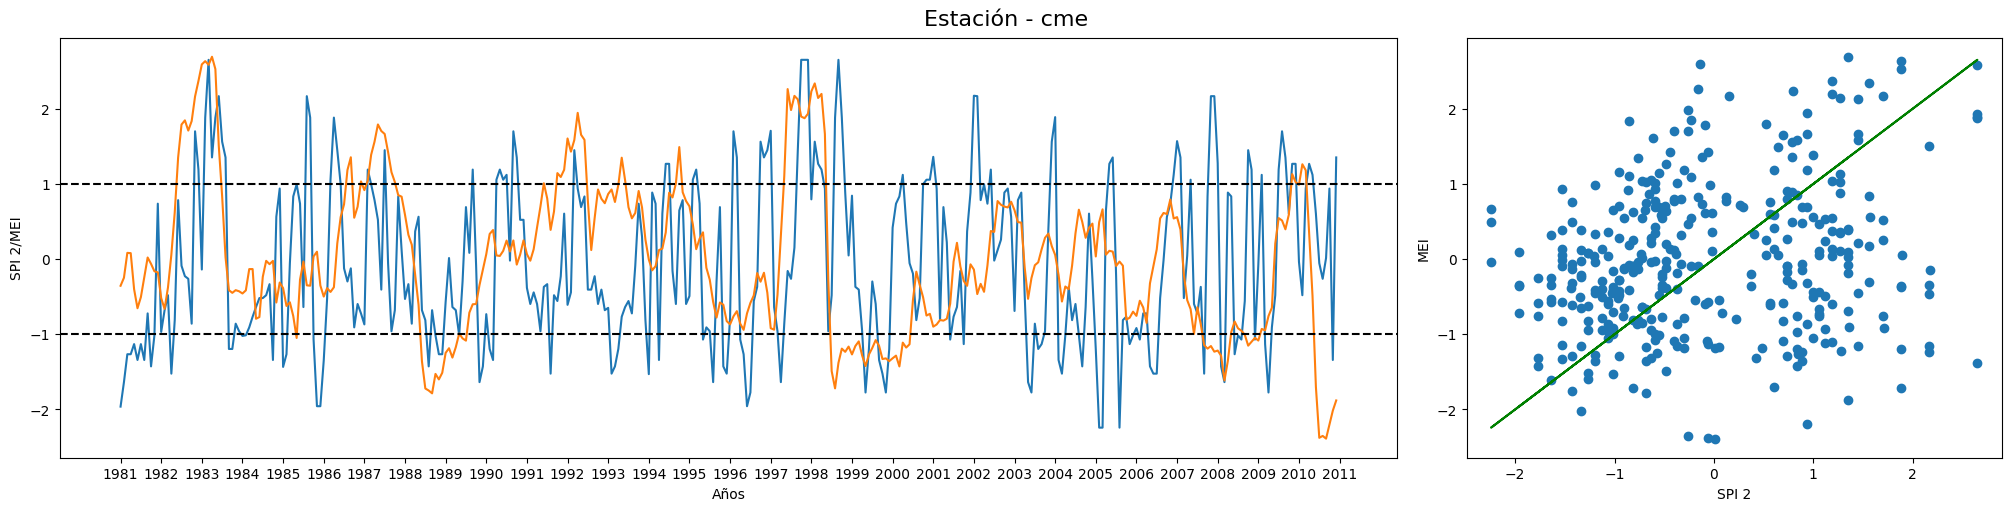

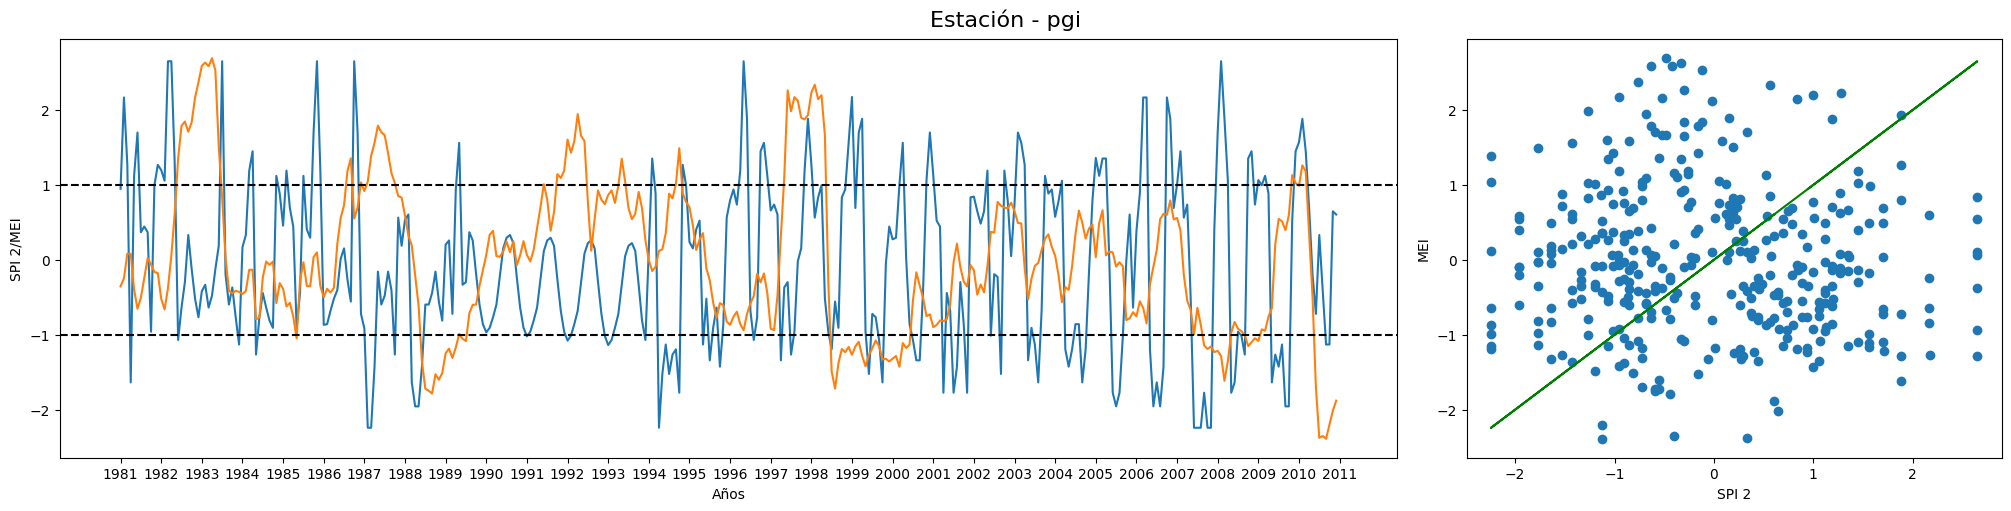

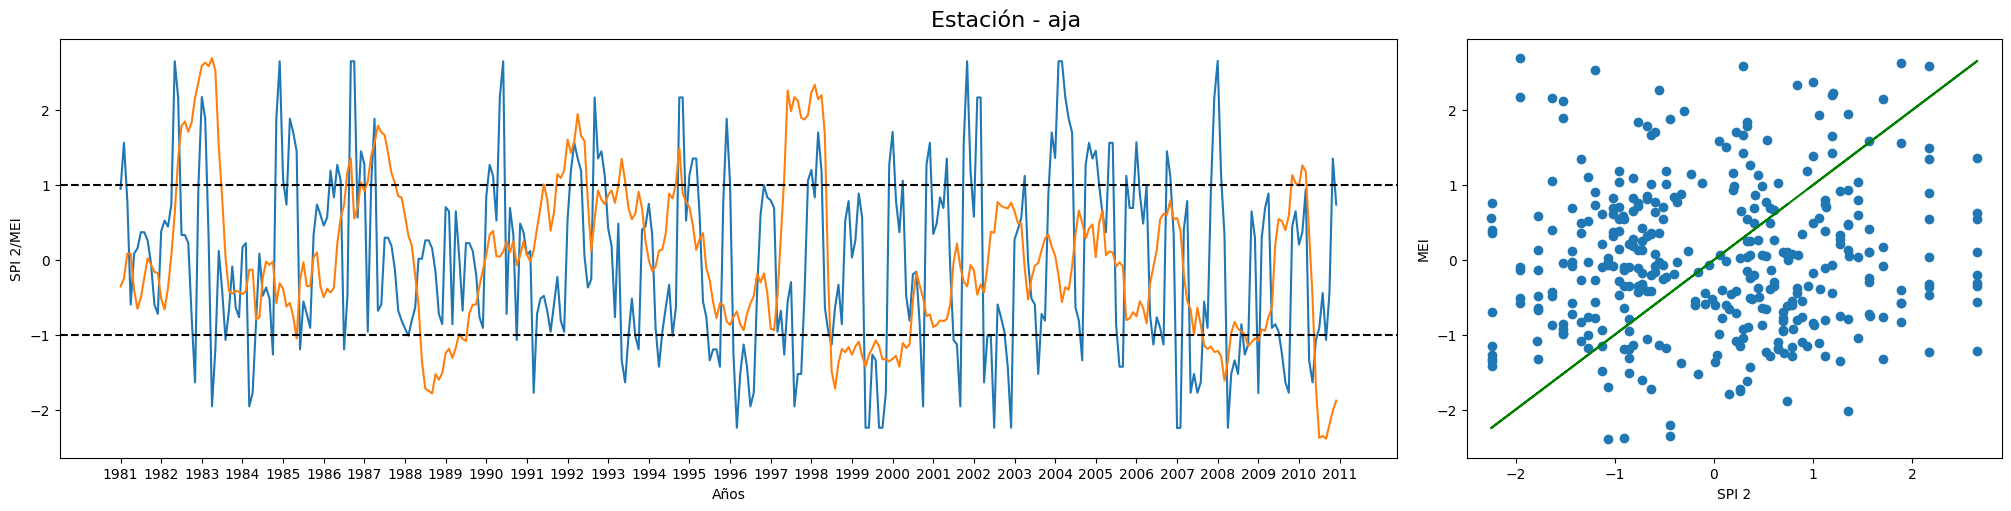

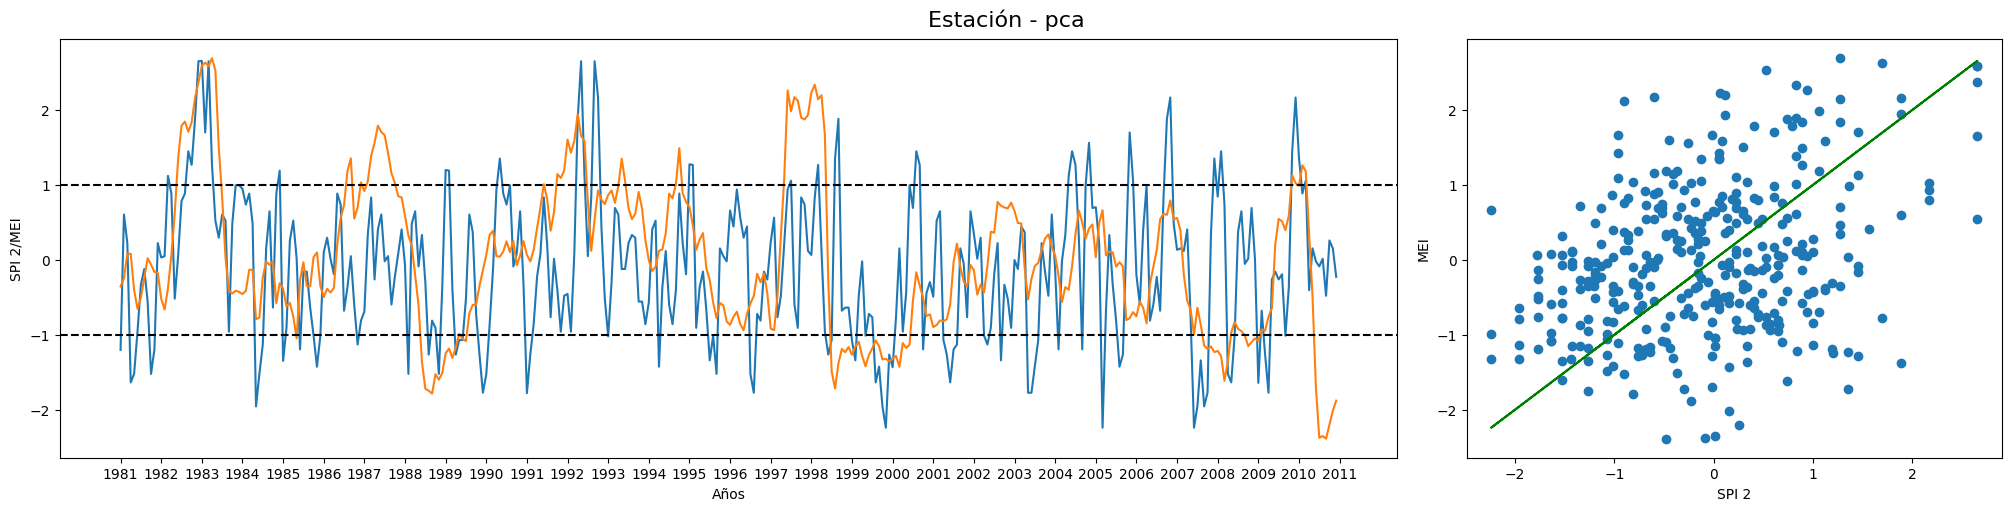

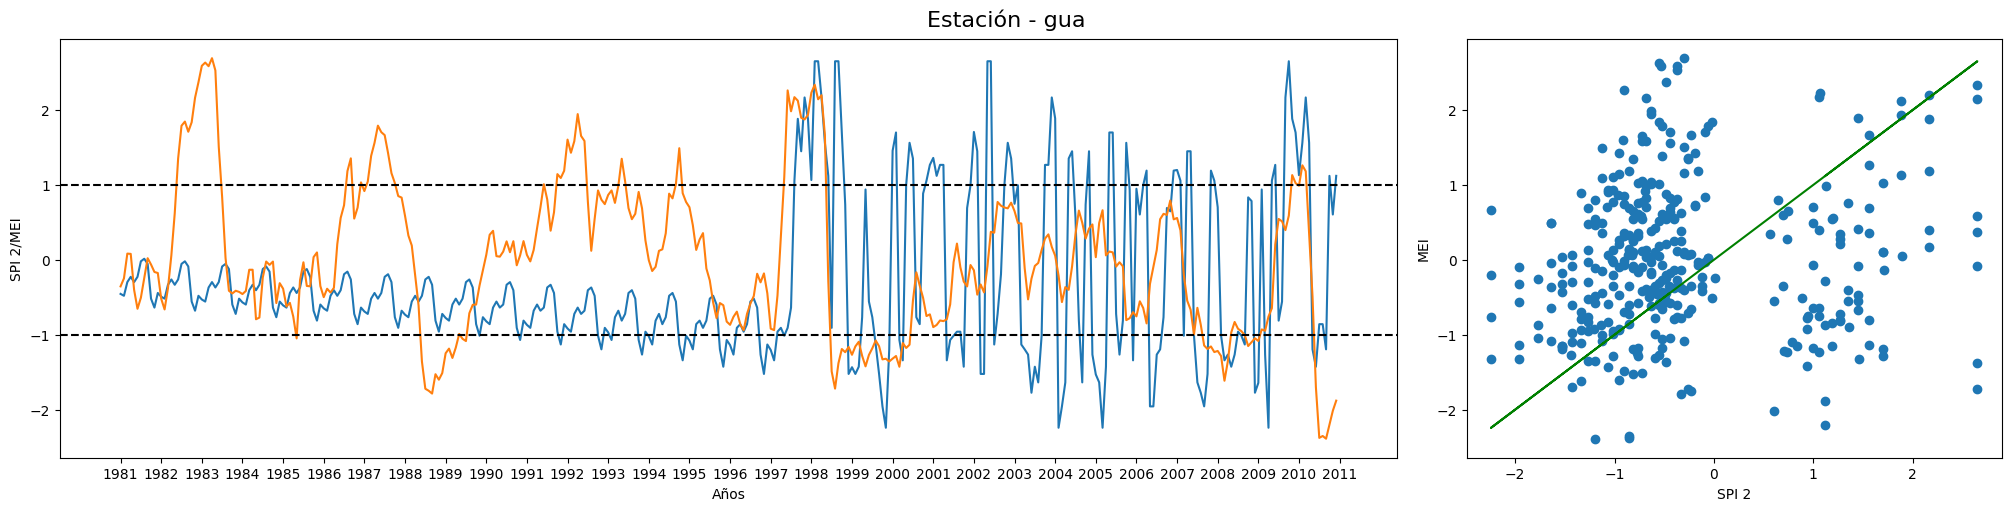

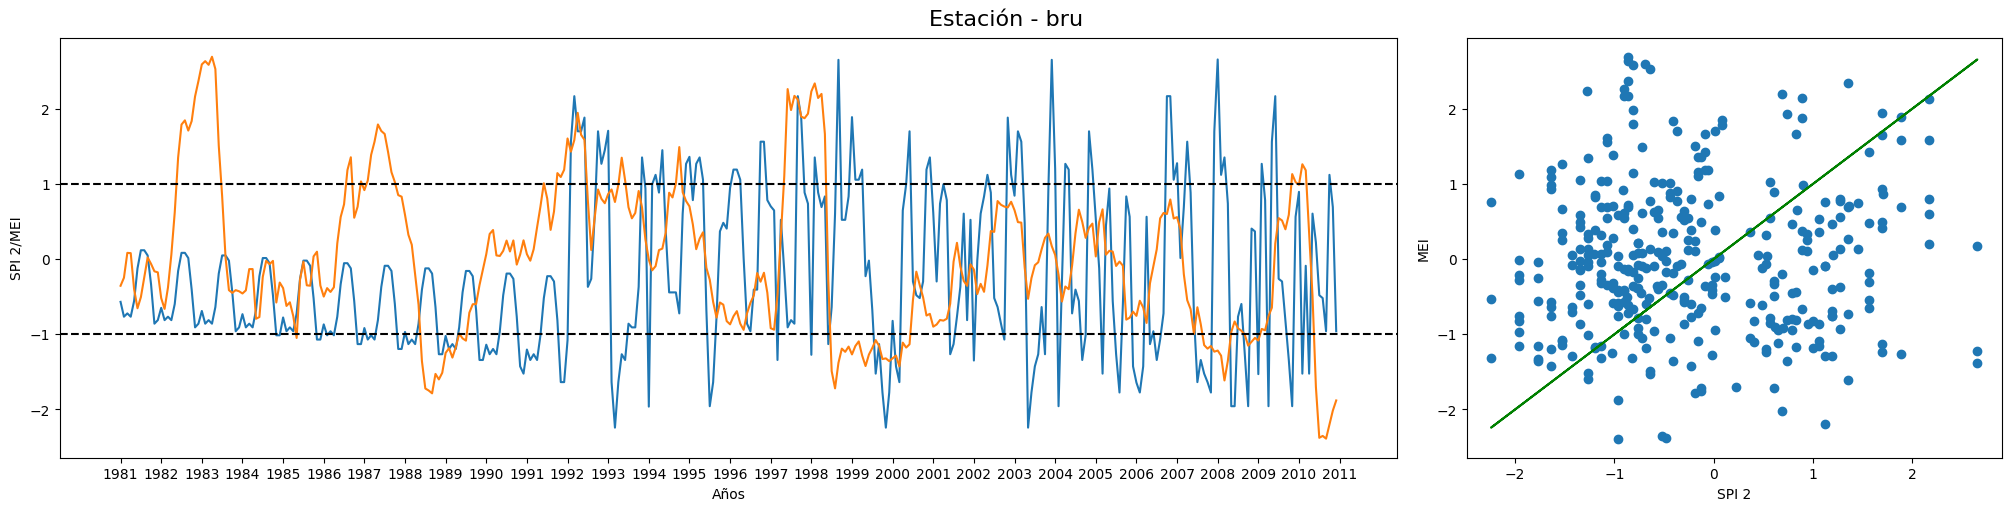

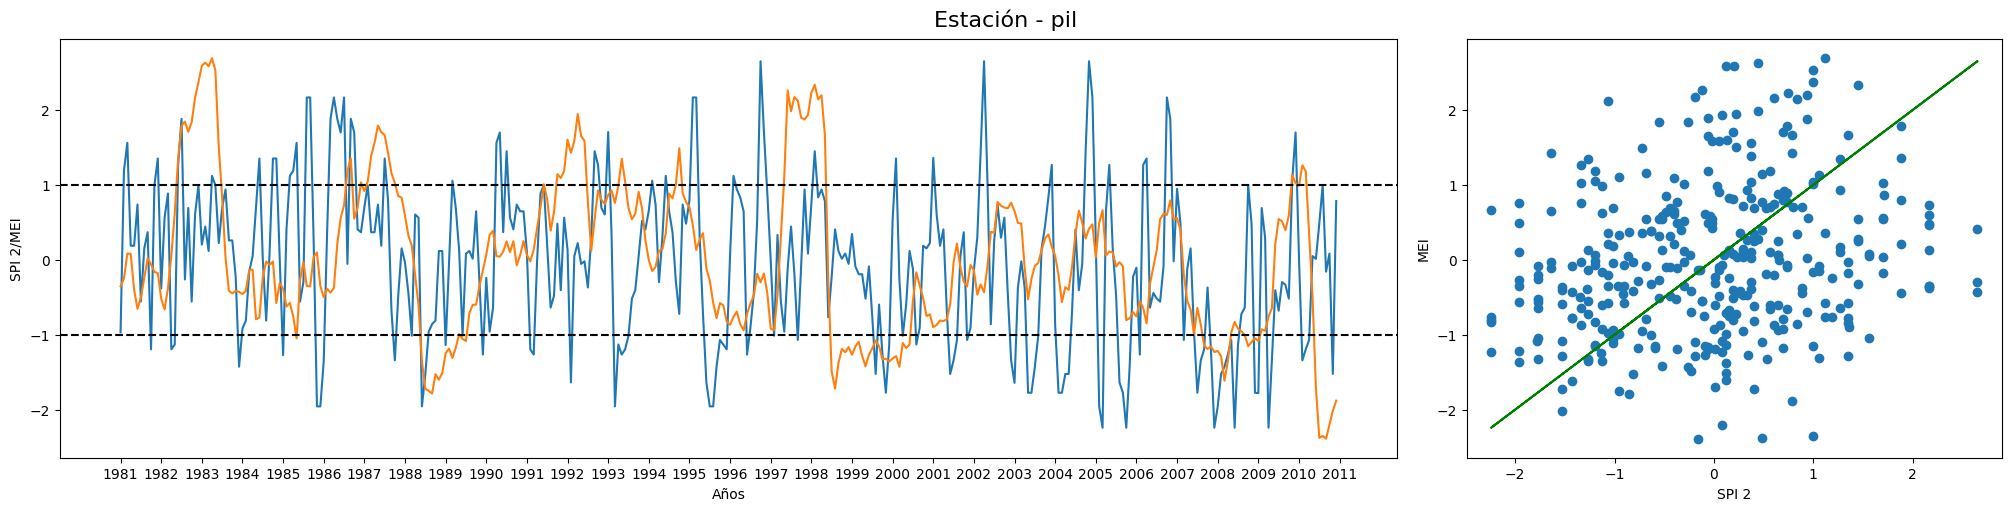

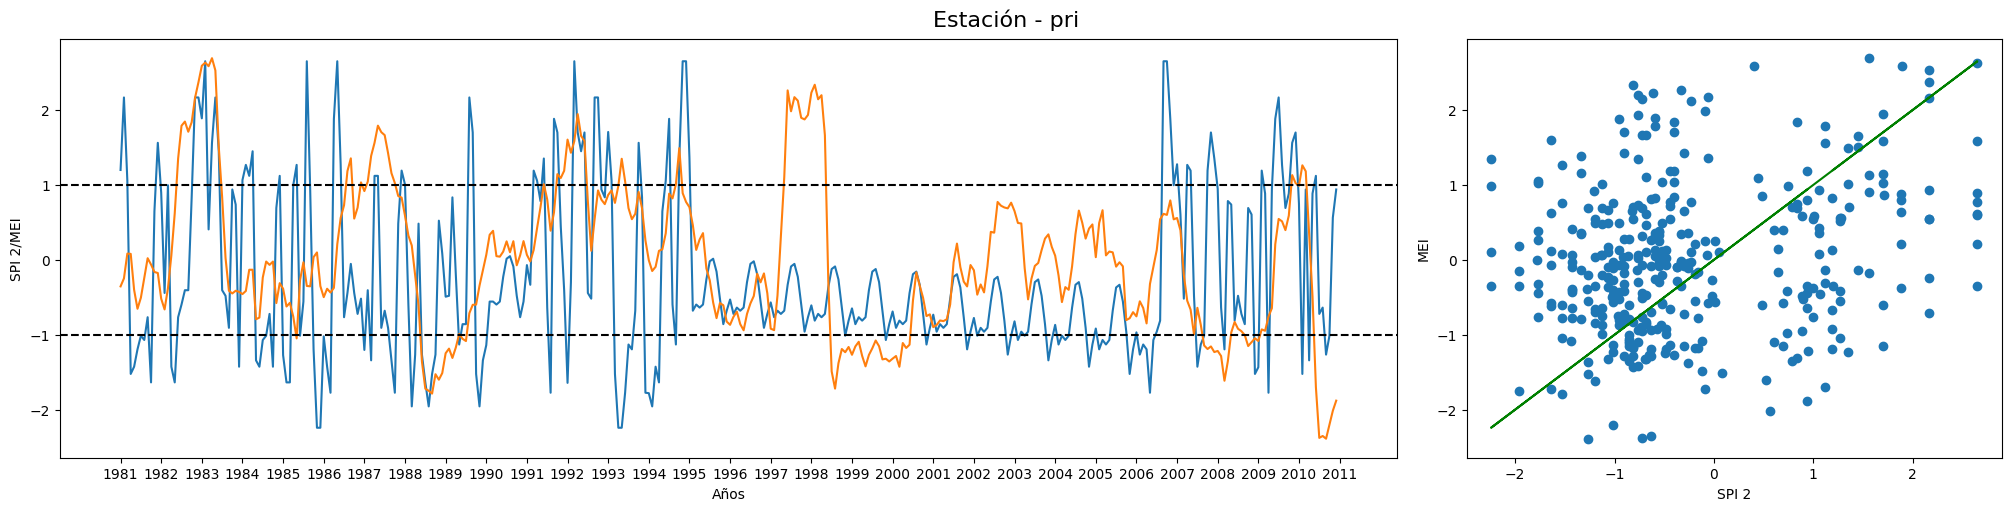

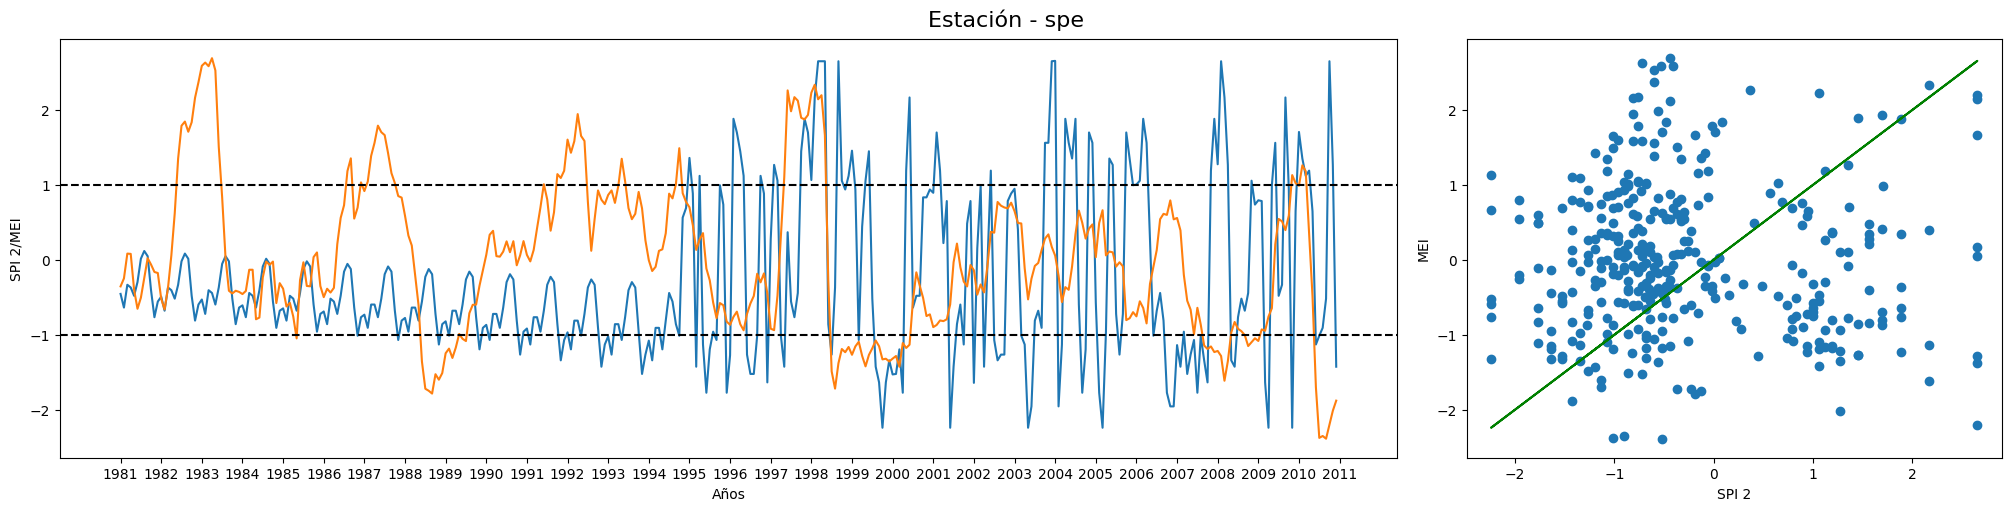

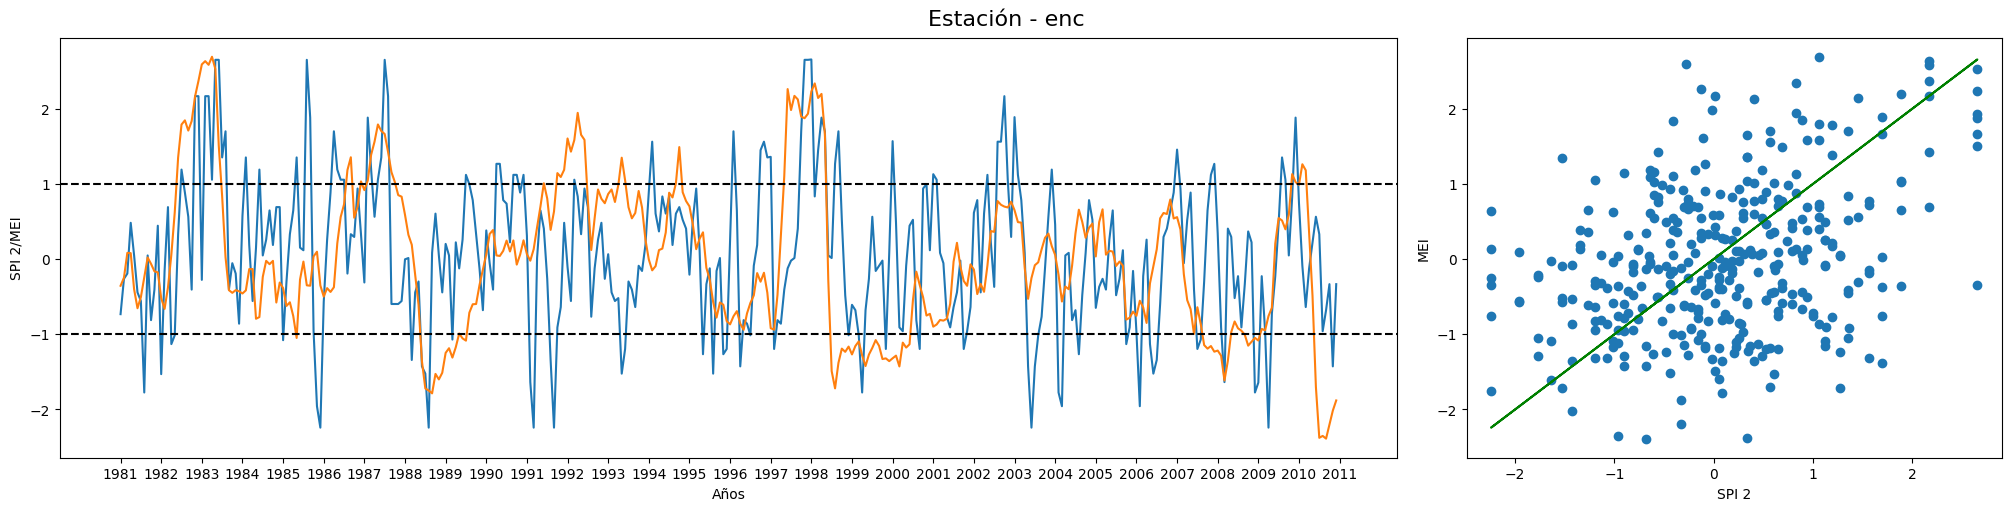

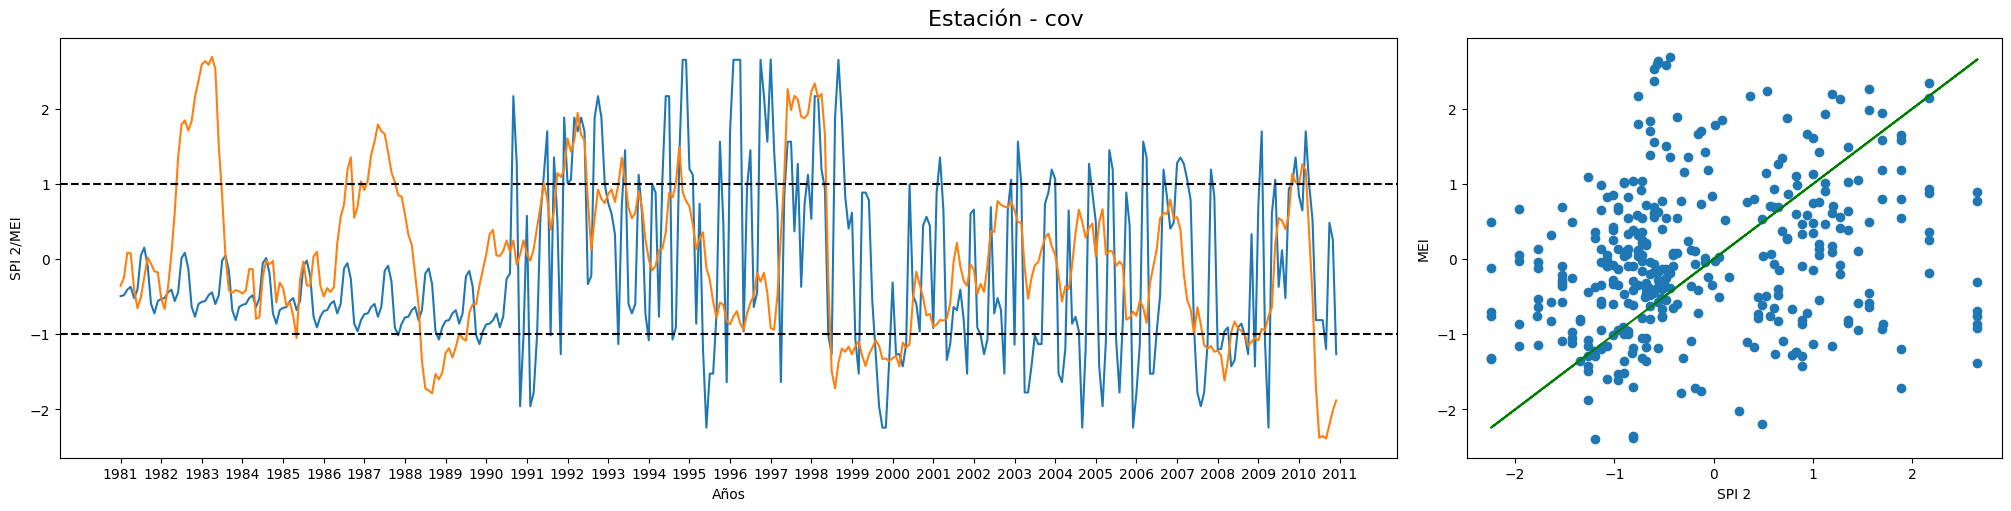

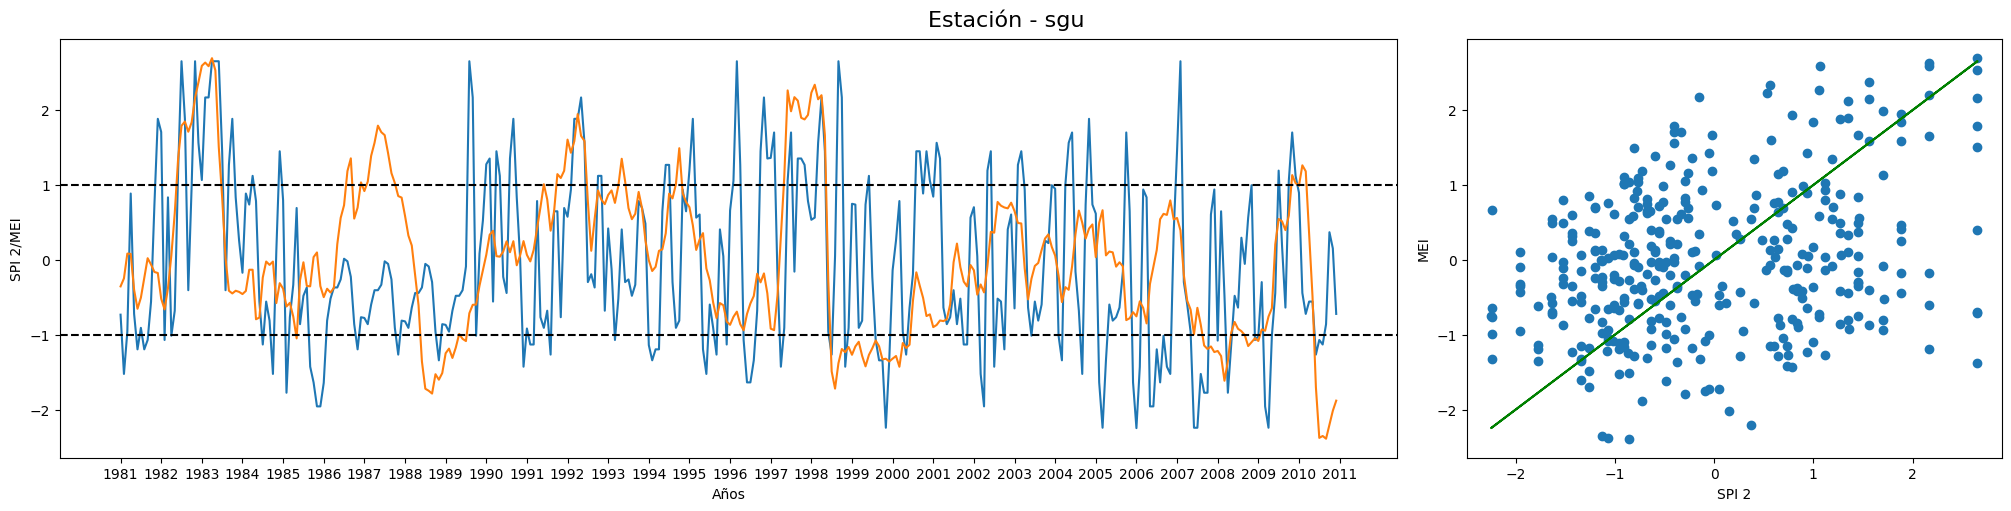

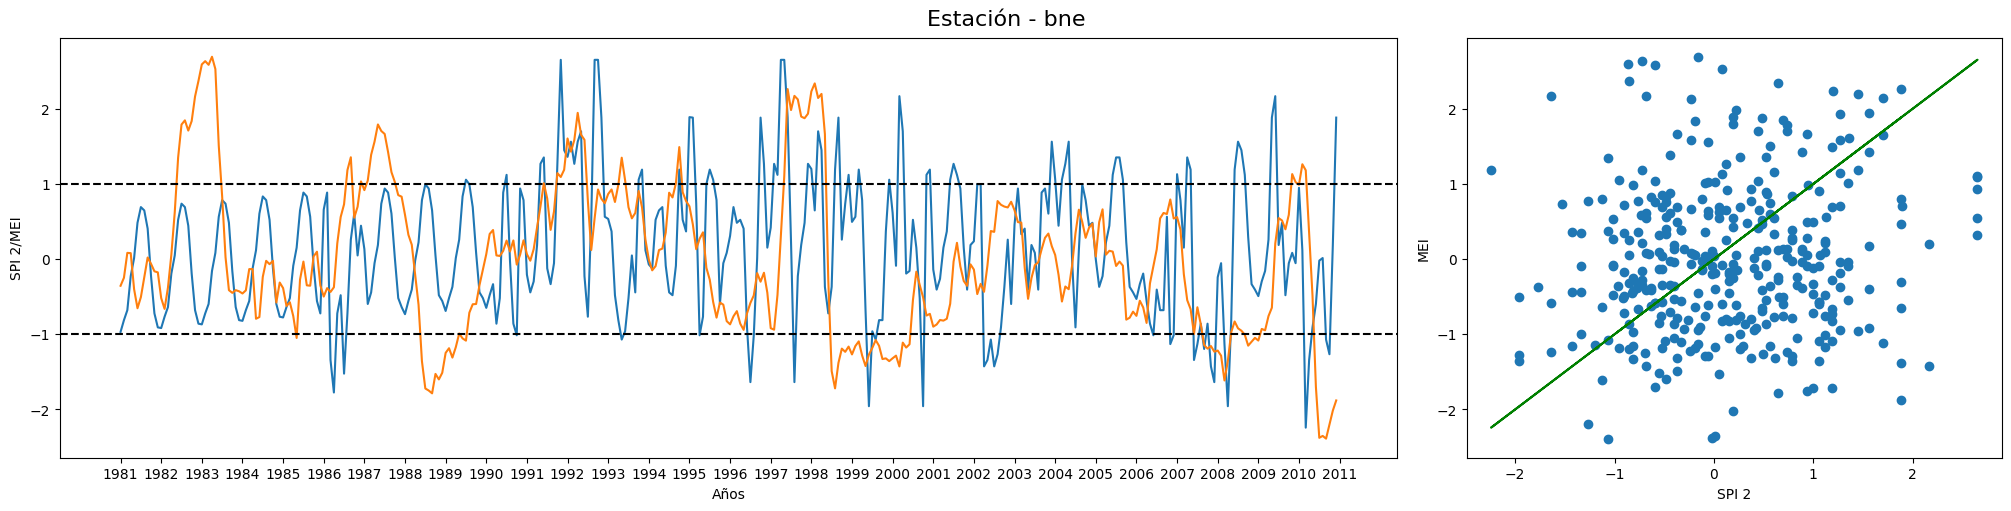

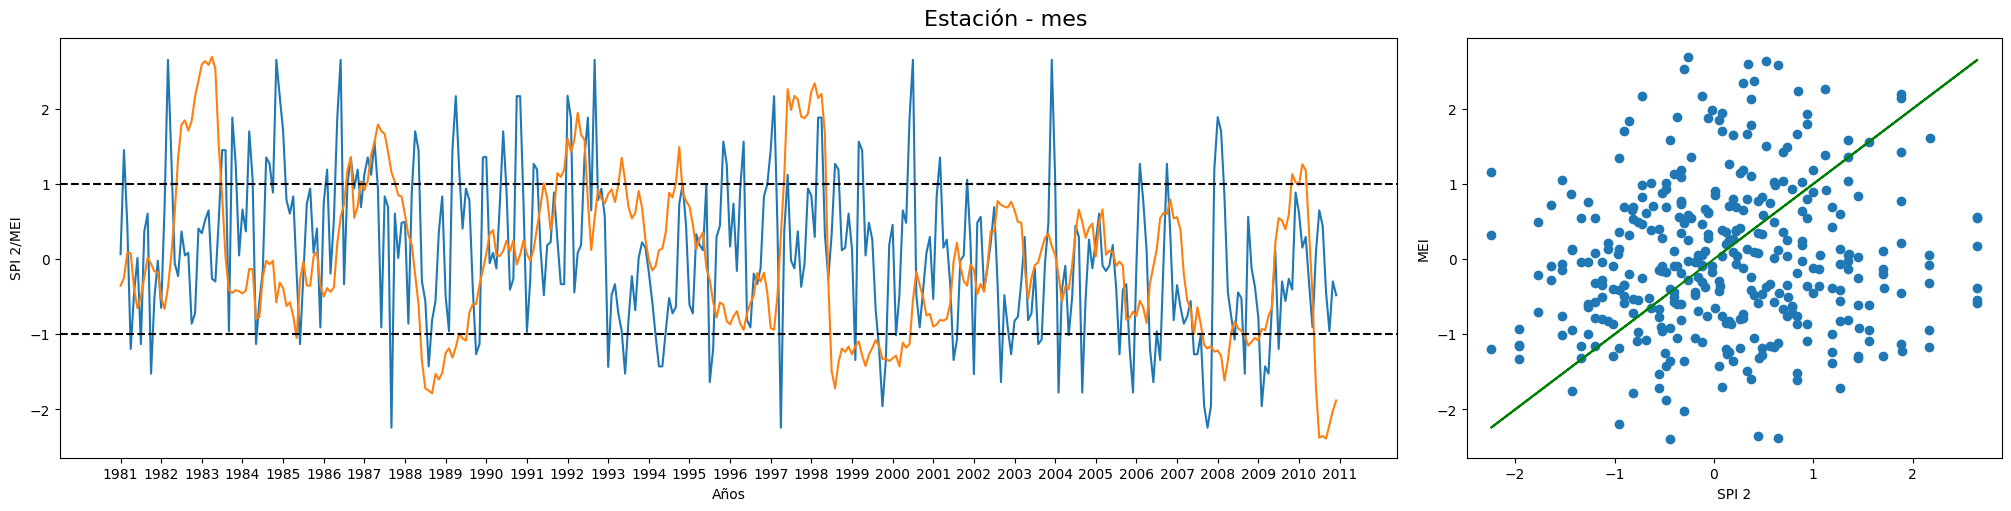

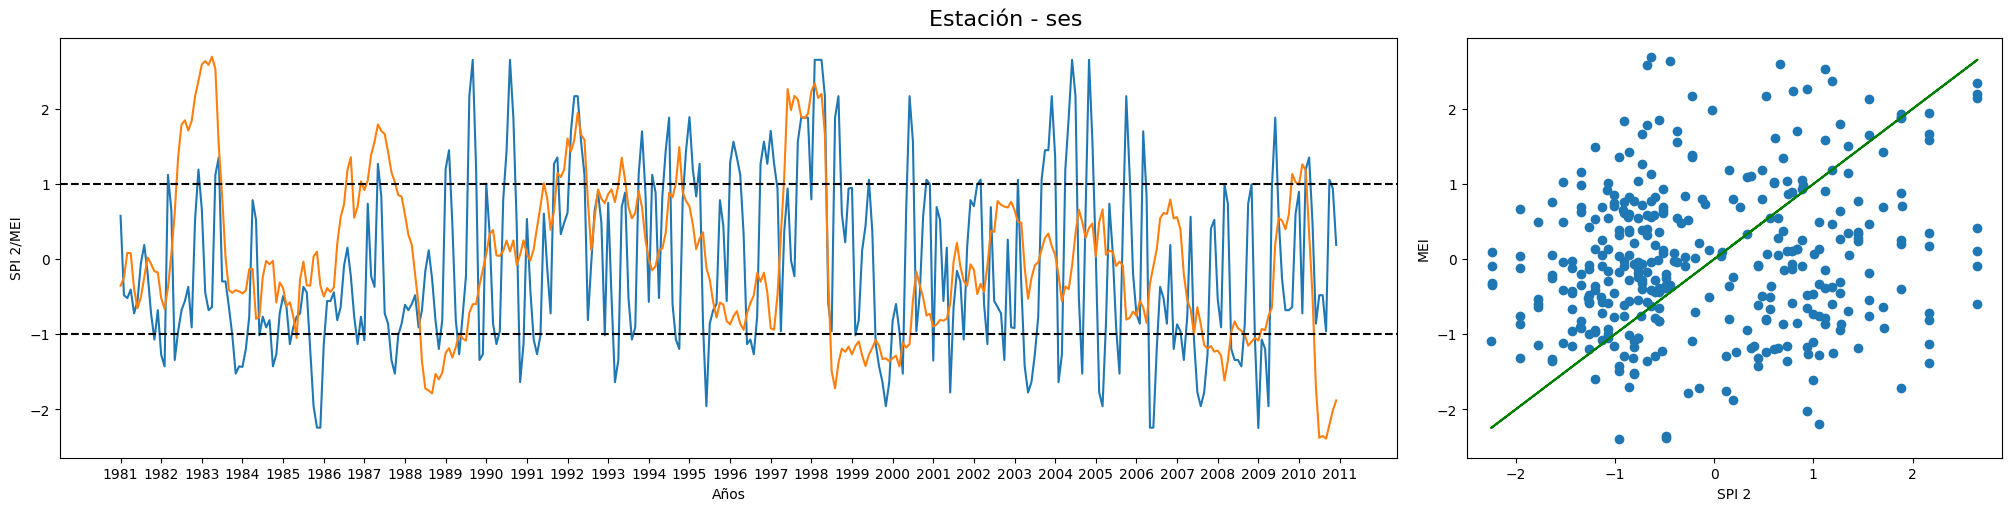

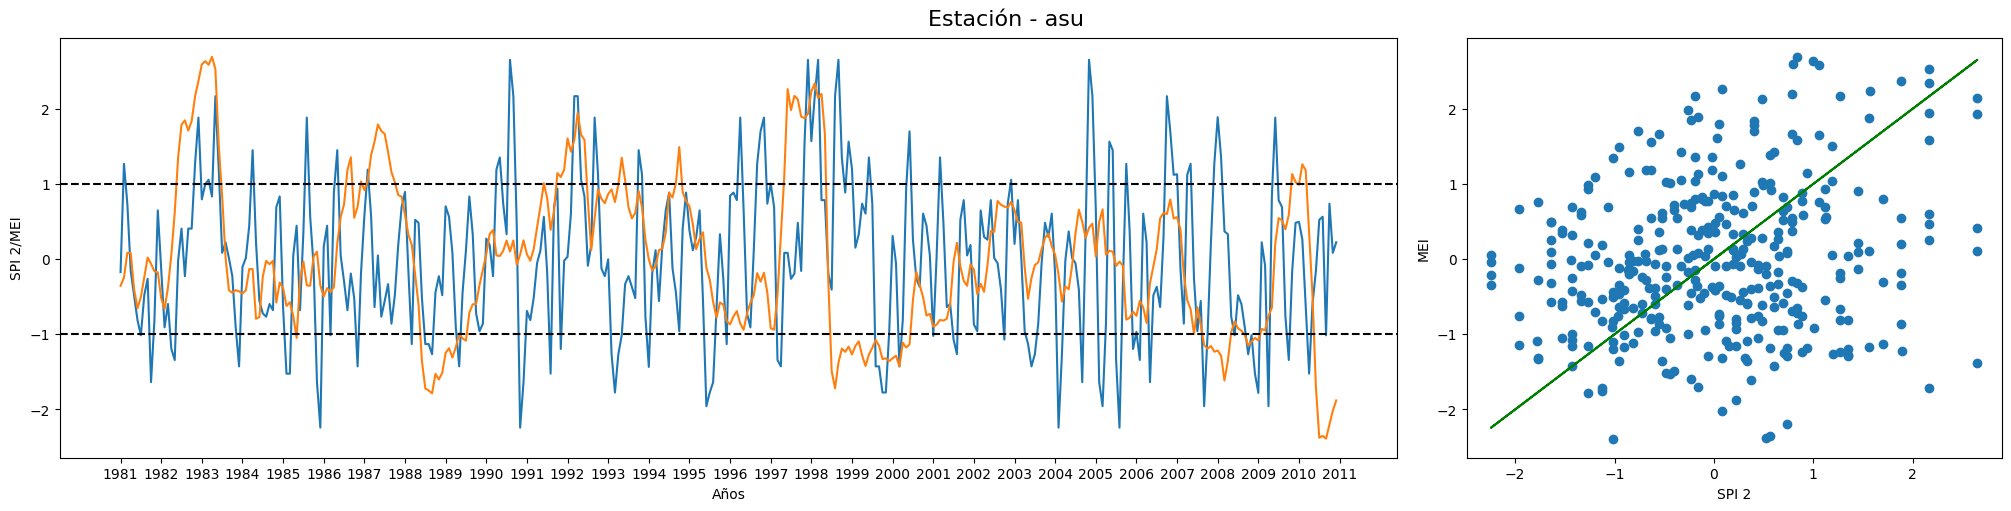

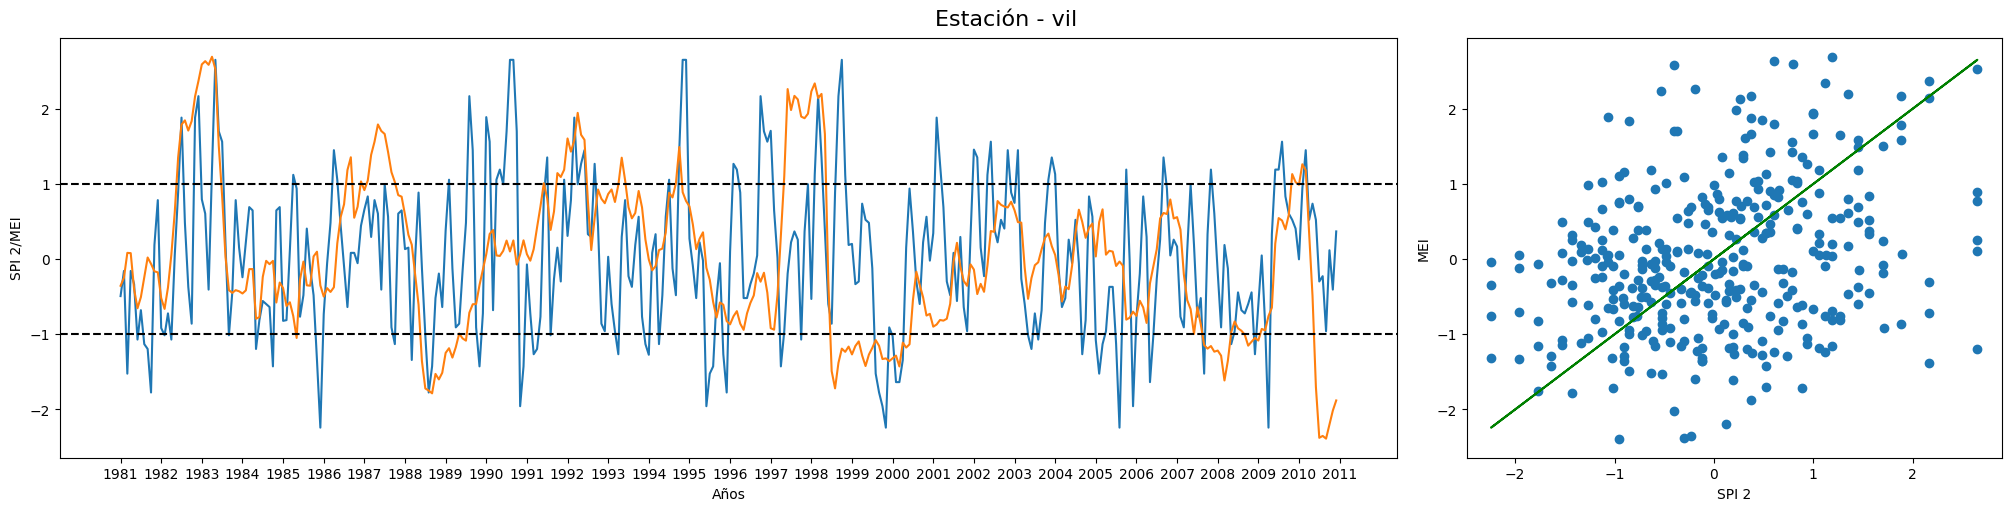

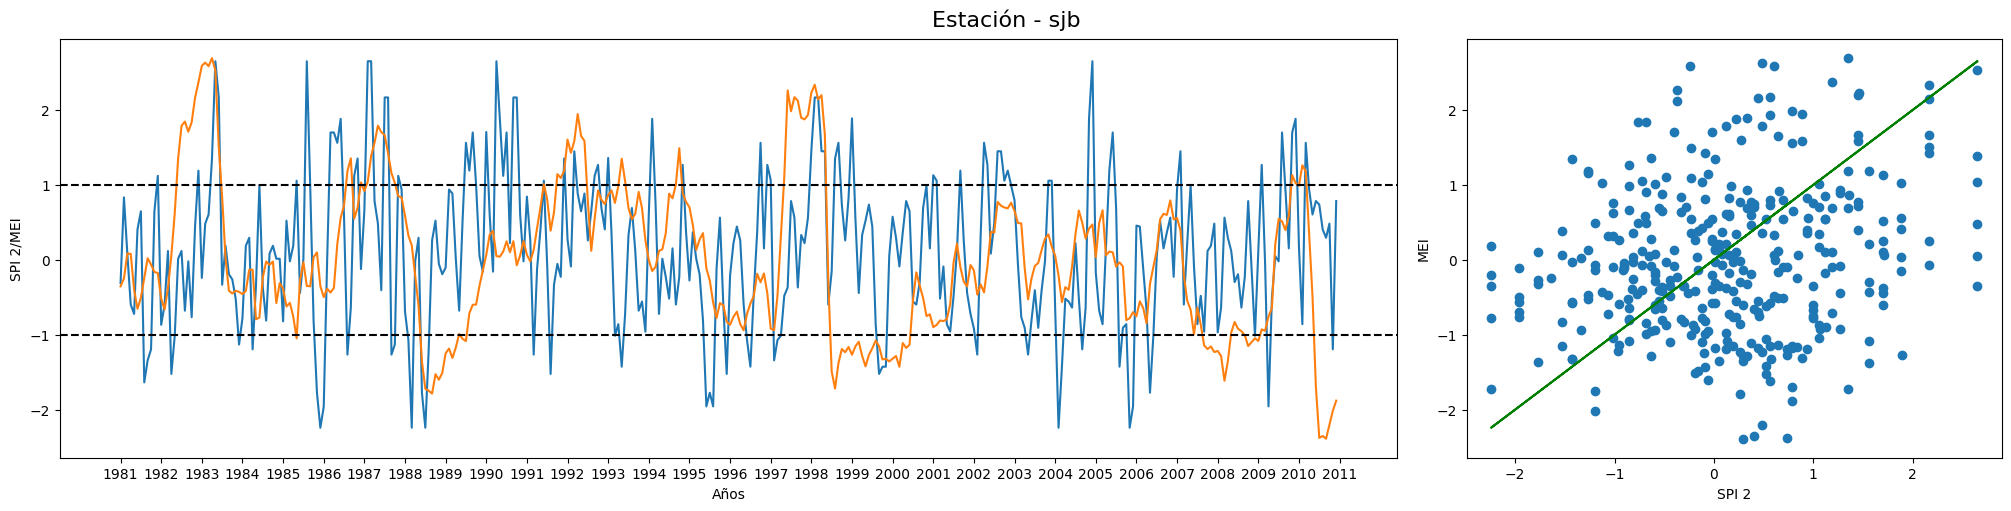

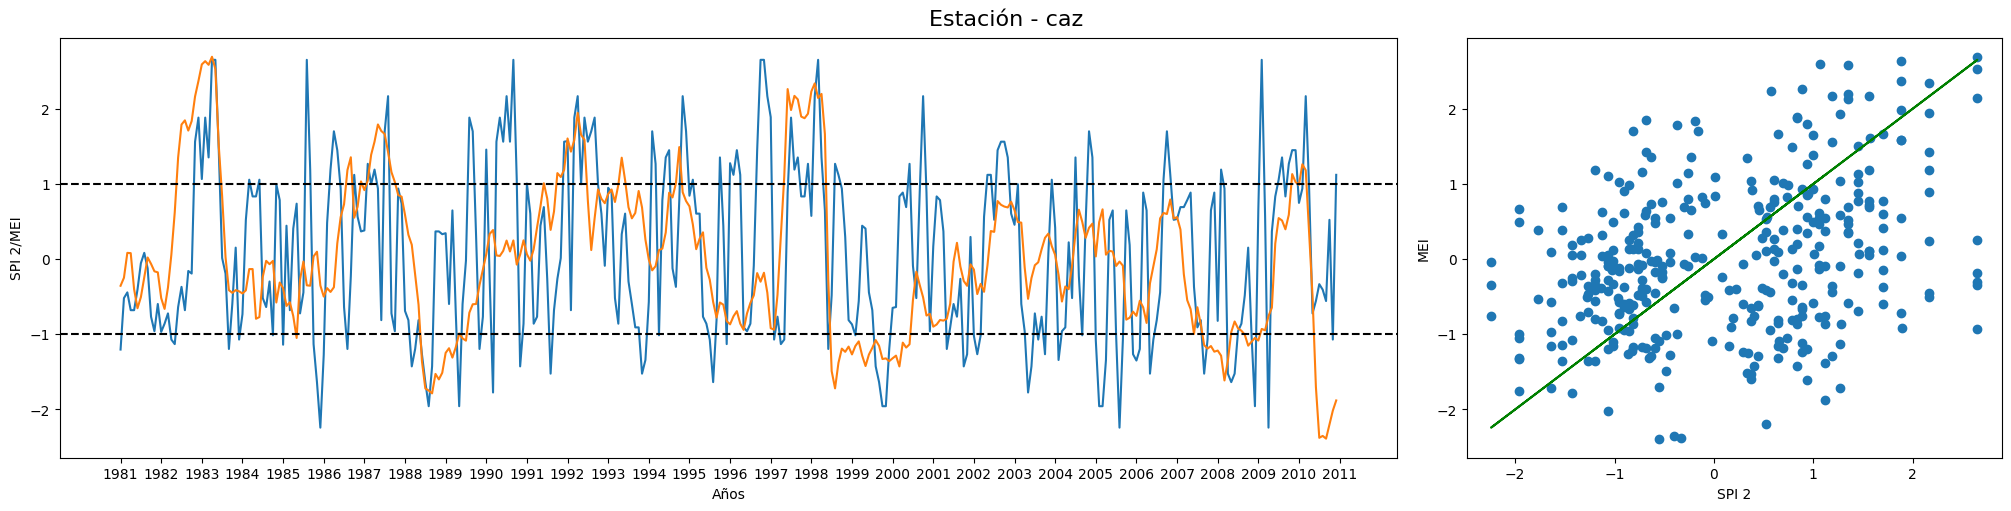

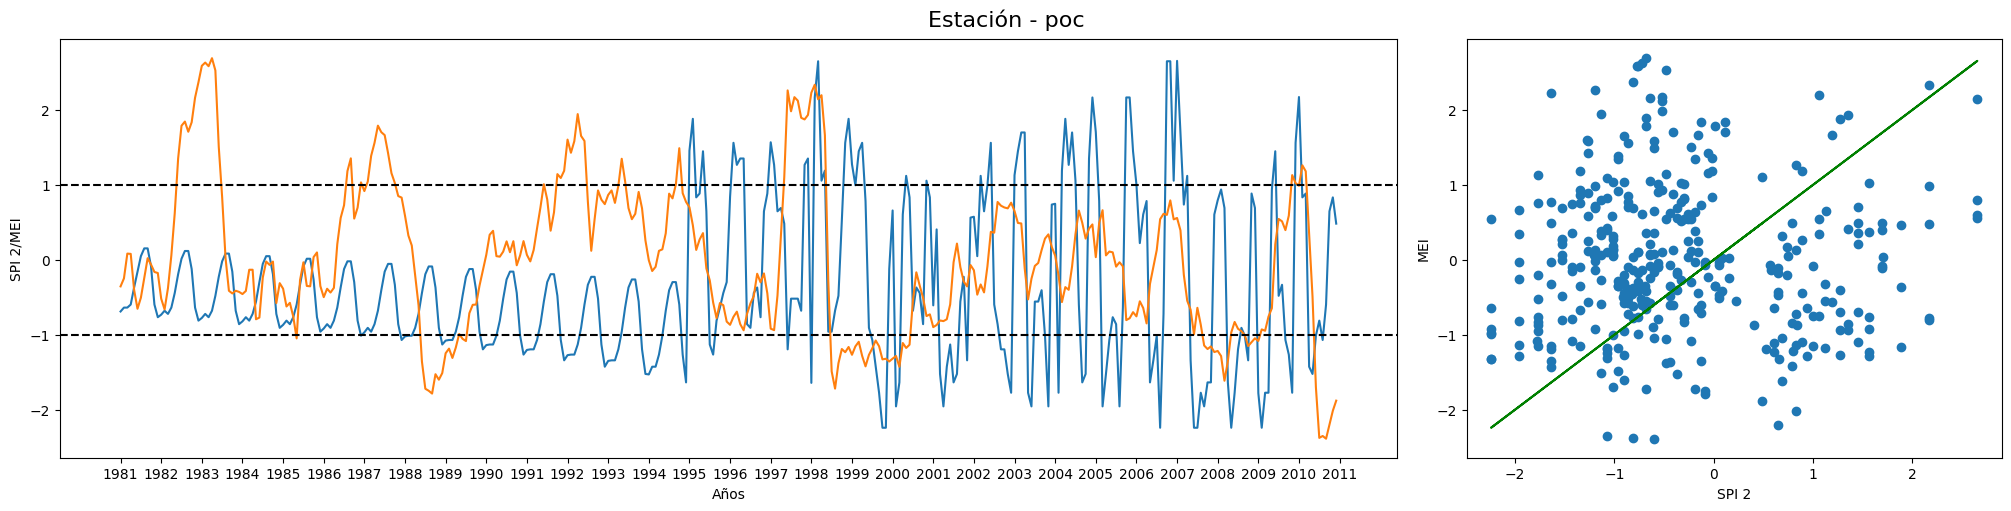

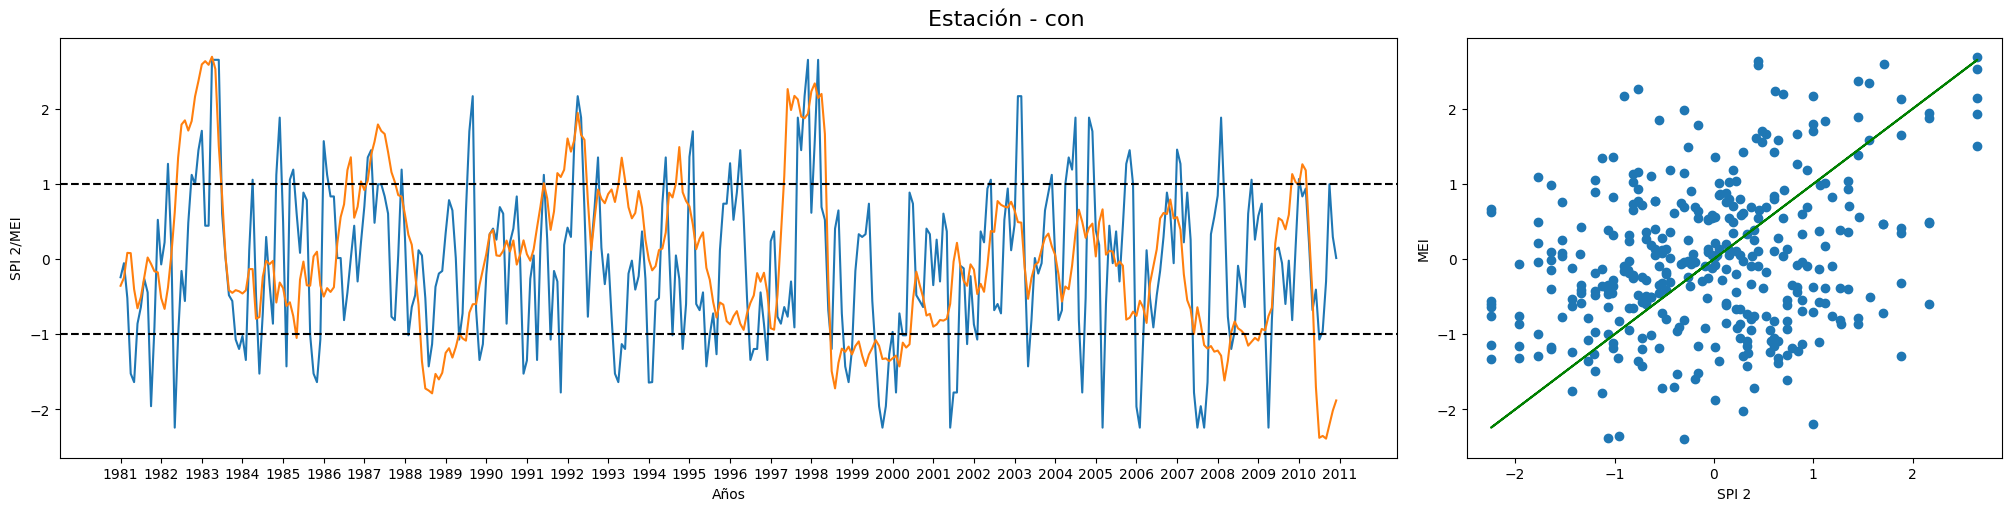

In [15]:
for key in database:
    if key=='mei':
        continue
    aux_dict = {}
    Y = pd.DataFrame(database[key].iloc[:,2:]['SPI_2'].values.reshape(30,12),columns=months)
    spi_ts = to_time_series(Y)
    mei_ts = to_time_series(A)
    mei_vs_spi(mei_ts,spi_ts,key)

Now two models where obtained but the $R^2$ values are too low to be considered. In the graphics showed above can be seen that there is no linear relationship exposed under this methodology with respect to the $SPI_2$ and the $\tilde{MEI}$ values. Howerer some relationship can be seen in the time series, so another methology must be applied in order to capture that relationship.  

<h2>04 - Conclusions</h2>
<p>The methodology applied in this work was not sufficient to capture a linear relationship, if one exists, between the $MEI$ values and the $SPI$ values from the different meteorological stations in Paraguay. Future work can consist of applying different regression techniques to answer the question of whether there is a relationship between these two values.</p>